<div class="alert alert-block alert-info">
<b>Tip:</b> Install the jupyter notebook first.
</div>

# Installing Jupyter Notebook in terminal

```bash
# Navigate to the home directory
cd ~

# Install Jupyter Notebook using pip3
pip3 install jupyter


# Plot those columns with less than 1006 missing value

In [1]:
# import modulus
import pandas as pd
# import os
# script_path = 'missing_table.py'
# os.system(f'python3 {script_path}')
# !python missing_table.py
from missing_table import missing_value_df
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# This function converts the string into the type of datetime %d/%m/%Y
def convert_date_format(date_str):
    try:
        date_time_obj = datetime.strptime(date_str, '%d/%m/%Y %H:%M')
        formatted_date = date_time_obj.strftime('%m/%d/%Y')
        return formatted_date
    except ValueError:
        pass

    try:
        date_time_obj = datetime.strptime(date_str, '%d/%m/%Y')
        return date_str
    except ValueError:
        raise ValueError(f"Unsupported date format: {date_str}")

In [3]:
#  FIRST TRY:
# note: More needs to be added to this script to clean the columns as needs be
# edit: 

# edit: changed filed path
df = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)
# Set the threshold for missing value count
# edit: change cound to 1006
thresh_value = 1006

# Extract the variable names with missing value counts larger than 1006
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df.drop(columns=columns_to_drop, inplace=True)
df.dropna(inplace=True)

# create a new column in the csv that computer from week 1 for every two weeks 
df["endtime"] = df["endtime"].apply(convert_date_format)
df["endtime"] = pd.to_datetime(df["endtime"])

# Find the start date (minimum date) and end date (maximum date)
start_date = df['endtime'].min()
end_date = df['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df['week_number'] = ((df['endtime'] - start_date).dt.days // 14) + 1

print(df)

       RecordNo    endtime    qweek i9_health        i11_health i12_health_1  \
0             0 2020-04-01   week 1       Yes      Very willing       Rarely   
1             1 2020-04-01   week 1       Yes      Very willing   Not at all   
2             2 2020-04-01   week 1       Yes      Very willing       Always   
3             3 2020-04-01   week 1       Yes      Very willing       Always   
4             4 2020-04-01   week 1       Yes  Somewhat willing   Not at all   
...         ...        ...      ...       ...               ...          ...   
52822     52822 2022-03-16  week 53        No  Somewhat willing   Frequently   
52823     52823 2022-03-16  week 53  Not sure      Very willing    Sometimes   
52824     52824 2022-03-16  week 53  Not sure      Very willing   Not at all   
52825     52825 2022-03-16  week 53       Yes      Very willing   Frequently   
52826     52826 2022-03-16  week 53        No      Very willing       Always   

      i12_health_2 i12_health_3 i12_hea

In [4]:
# plot states_in_proportion pre-setting

df["endtime"] = pd.to_datetime(df["endtime"])   
df = df.sort_values(by=["endtime"])

frequency_dict = {"Always": 1, "Frequently": 1, "Sometimes": 0, "Rarely": 0, "Not at all": 0}
df["i12_health_1"] = df["i12_health_1"].map(frequency_dict)

# Assuming df is your original dataframe
df_count = df.groupby(["week_number", "state", "i12_health_1"]).size().unstack(fill_value=0).reset_index()
df_count.columns = ["week_number", "state", 
                    "wearing mask = 'No'", "wearing mask = 'Yes'"]
# plot figures in states. proportion
df_count["prop_no"] = df_count["wearing mask = 'No'"] / (df_count["wearing mask = 'No'"] + df_count["wearing mask = 'Yes'"])
df_count["prop_yes"] = df_count["wearing mask = 'Yes'"] / (df_count["wearing mask = 'No'"] + df_count["wearing mask = 'Yes'"])
# the regulation dates
states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}

print(df_count)

     week_number                         state  wearing mask = 'No'  \
0              1  Australian Capital Territory                   23   
1              1               New South Wales                  395   
2              1            Northern Territory                   14   
3              1                    Queensland                  324   
4              1               South Australia                  155   
..           ...                           ...                  ...   
392           52               New South Wales                    5   
393           52                    Queensland                    5   
394           52               South Australia                    1   
395           52                      Victoria                    3   
396           52             Western Australia                    1   

     wearing mask = 'Yes'   prop_no  prop_yes  
0                       8  0.741935  0.258065  
1                     190  0.675214  0.324786  
2  

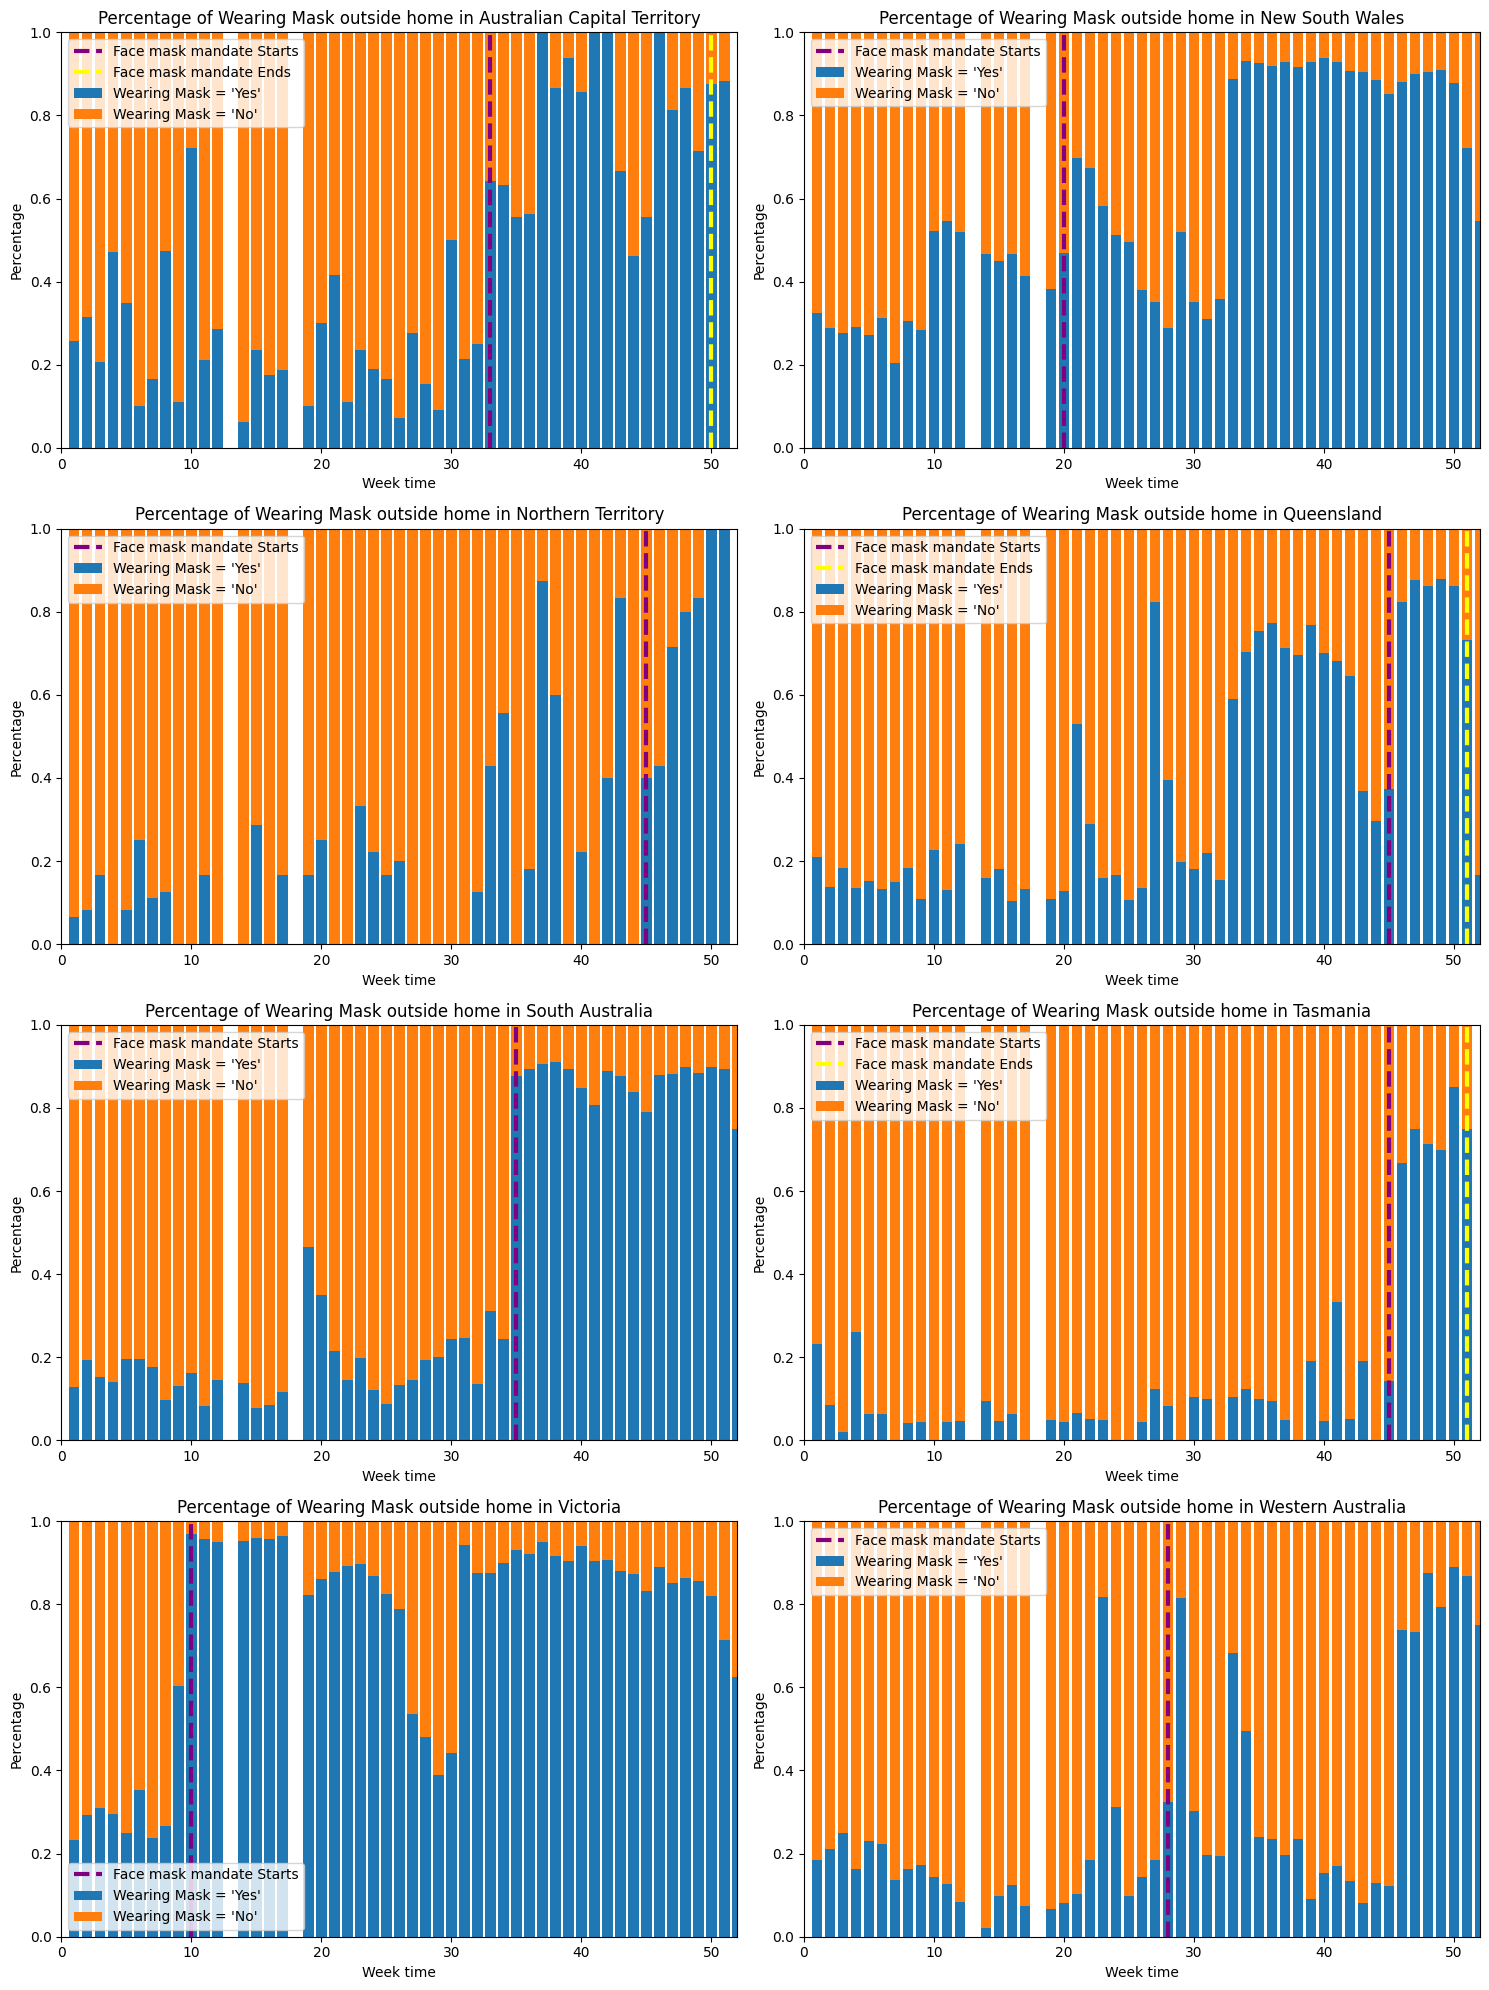

In [8]:
# Plotting figures for each state in two columns
states = df_count["state"].unique()
num_states = len(states)

fig, axes = plt.subplots(num_states // 2, 2, figsize=(15, 5 * (num_states // 2 + num_states % 2)))

for idx, state in enumerate(states):
    ax = axes[idx // 2, idx % 2] if num_states > 1 else axes
    
    state_df = df_count[df_count["state"] == state]
    
    ax.bar(state_df["week_number"], state_df["prop_yes"], label="Wearing Mask = 'Yes'")
    ax.bar(state_df["week_number"], state_df["prop_no"], bottom=state_df["prop_yes"], label="Wearing Mask = 'No'")
    
    # Add vertical lines for start and end times
    start_time, end_time = states_data[state]
        
    if start_time:
        start_time = pd.to_datetime(start_time, format='%d/%m/%Y')
        ax.axvline(x=((start_time - start_date).days // 14) + 1, color='purple', linestyle='--', linewidth = 3, label='Face mask mandate Starts')
    if end_time and (state == "Australian Capital Territory" or state == "Northen Territory" or state == "Queensland" or state == "Tasmania"):
        end_time = pd.to_datetime(end_time, format='%d/%m/%Y')
        ax.axvline(x=((end_time - start_date).days // 14) + 1, color='yellow', linestyle='--', linewidth = 3, label='Face mask mandate Ends')
        
    ax.set_title(f"Percentage of Wearing Mask outside home in {state}")
    ax.set_xlabel("Week time")
    ax.set_ylabel("Percentage")
    ax.set_xlim(0,52)
    ax.set_ylim(0, 1)  # Fixing y-axis at 1
    ax.legend()

plt.tight_layout()
plt.savefig("../figures/states_in_proportion_threshold1006.png")
plt.show()

In [6]:
# ANOTHER TRY: threshold = 10029
# note: More needs to be added to this script to clean the columns as needs be

# edit: changed filed path
df = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)
# Set the threshold for missing value count
# edit: change cound to 10029
thresh_value = 10029

# Extract the variable names with missing value counts larger than 10029
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df.drop(columns=columns_to_drop, inplace=True)
df.dropna(inplace=True)

# create a new column in the csv that computer from week 1 for every two weeks 
df["endtime"] = df["endtime"].apply(convert_date_format)
df["endtime"] = pd.to_datetime(df["endtime"])

# Find the start date (minimum date) and end date (maximum date)
start_date = df['endtime'].min()
end_date = df['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df['week_number'] = ((df['endtime'] - start_date).dt.days // 14) + 1

print(df)

       RecordNo    endtime    qweek  i2_health i9_health  \
9023       9023 2020-06-24  week 10        0.0  Not sure   
9024       9024 2020-06-24  week 10        2.0        No   
9025       9025 2020-06-24  week 10        6.0       Yes   
9026       9026 2020-06-24  week 10       20.0       Yes   
9027       9027 2020-06-24  week 10        0.0       Yes   
...         ...        ...      ...        ...       ...   
51826     51826 2022-02-26  week 52        6.0        No   
51827     51827 2022-02-26  week 52        4.0       Yes   
51828     51828 2022-03-01  week 52        3.0       Yes   
51829     51829 2022-03-01  week 52       10.0       Yes   
51830     51830 2022-03-01  week 52      100.0        No   

                          i11_health i12_health_1 i12_health_2 i12_health_3  \
9023                        Not sure    Sometimes       Rarely    Sometimes   
9024                    Very willing   Frequently    Sometimes    Sometimes   
9025                    Very willing   Not

In [7]:
# plot states_in_proportion pre-setting

df["endtime"] = pd.to_datetime(df["endtime"])   
df = df.sort_values(by=["endtime"])

frequency_dict = {"Always": 1, "Frequently": 1, "Sometimes": 0, "Rarely": 0, "Not at all": 0}
df["i12_health_1"] = df["i12_health_1"].map(frequency_dict)

# Assuming df is your original dataframe
df_count = df.groupby(["week_number", "state", "i12_health_1"]).size().unstack(fill_value=0).reset_index()
df_count.columns = ["week_number", "state", 
                    "wearing mask = 'No'", "wearing mask = 'Yes'"]
# plot figures in states. proportion
df_count["prop_no"] = df_count["wearing mask = 'No'"] / (df_count["wearing mask = 'No'"] + df_count["wearing mask = 'Yes'"])
df_count["prop_yes"] = df_count["wearing mask = 'Yes'"] / (df_count["wearing mask = 'No'"] + df_count["wearing mask = 'Yes'"])

print(df_count)

     week_number                         state  wearing mask = 'No'  \
0              1  Australian Capital Territory                   15   
1              1               New South Wales                  235   
2              1            Northern Territory                    8   
3              1                    Queensland                  175   
4              1               South Australia                   61   
..           ...                           ...                  ...   
331           44                    Queensland                   27   
332           44               South Australia                    9   
333           44                      Tasmania                    3   
334           44                      Victoria                   45   
335           44             Western Australia                    9   

     wearing mask = 'Yes'   prop_no  prop_yes  
0                       3  0.833333  0.166667  
1                      61  0.793919  0.206081  
2  

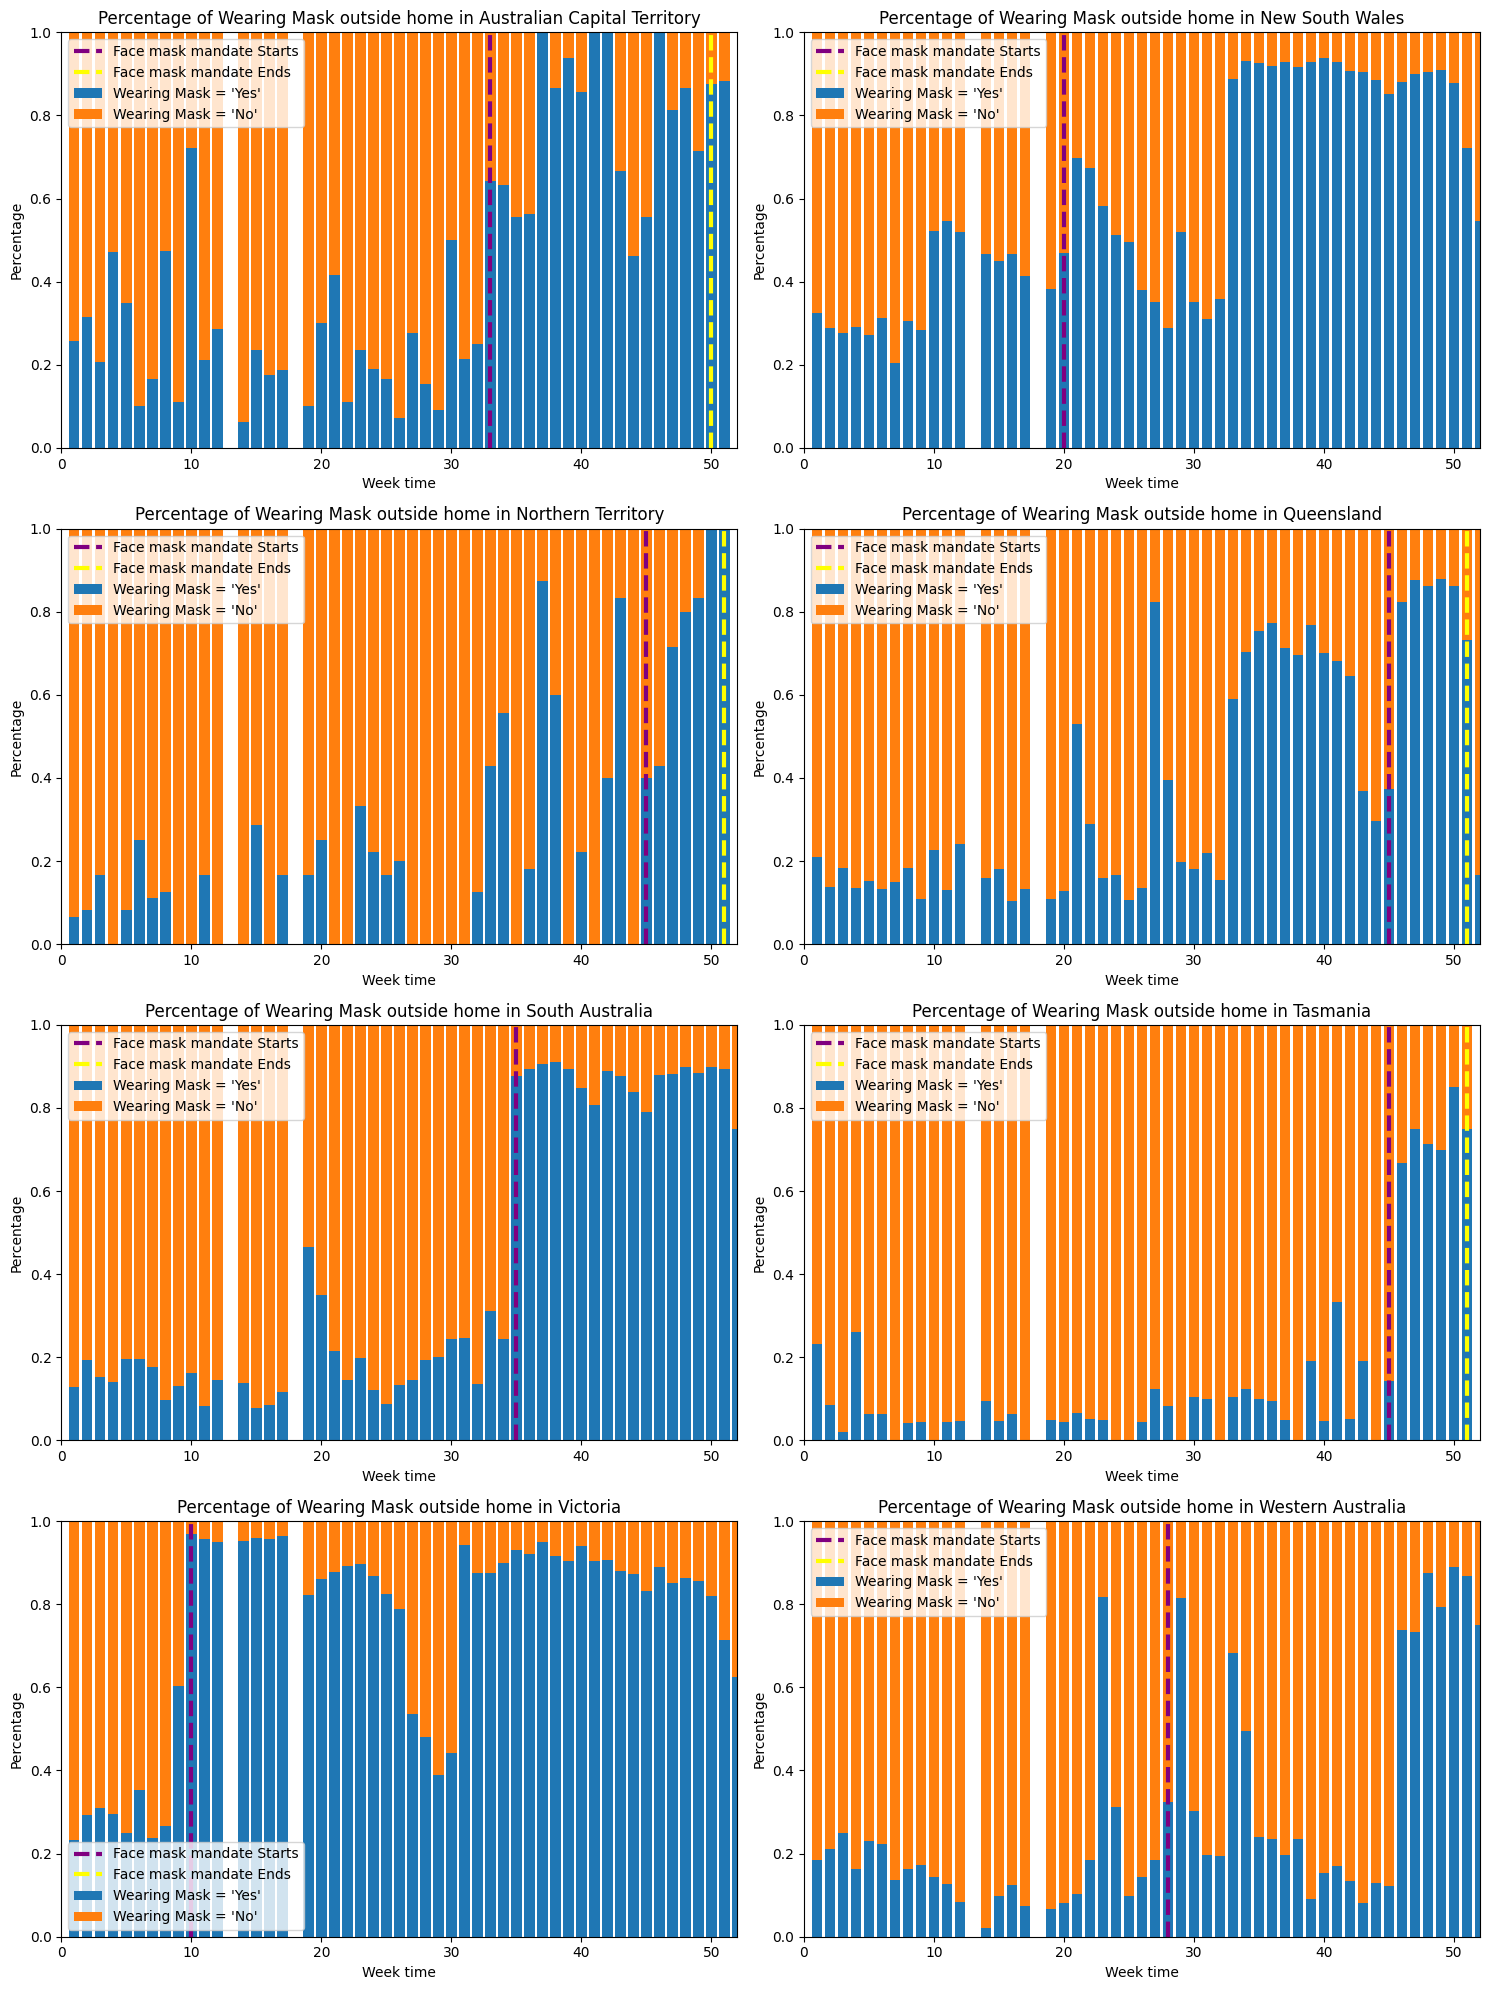

In [7]:
# Plotting figures for each state in two columns
states = df_count["state"].unique()
num_states = len(states)

fig, axes = plt.subplots(num_states // 2, 2, figsize=(15, 5 * (num_states // 2 + num_states % 2)))

for idx, state in enumerate(states):
    ax = axes[idx // 2, idx % 2] if num_states > 1 else axes
    
    state_df = df_count[df_count["state"] == state]
    
    ax.bar(state_df["week_number"], state_df["prop_yes"], label="Wearing Mask = 'Yes'")
    ax.bar(state_df["week_number"], state_df["prop_no"], bottom=state_df["prop_yes"], label="Wearing Mask = 'No'")
    
    # Add vertical lines for start and end times
    start_time, end_time = states_data[state]
    if start_time:
        start_time = pd.to_datetime(start_time, format='%d/%m/%Y')
        ax.axvline(x=((start_time - start_date).days // 14) + 1, color='purple', linestyle='--', linewidth = 3, label='Face mask mandate Starts')
    if end_time:
        end_time = pd.to_datetime(end_time, format='%d/%m/%Y')
        ax.axvline(x=((end_time - start_date).days // 14) + 1, color='yellow', linestyle='--', linewidth = 3, label='Face mask mandate Ends')
        
    ax.set_title(f"Percentage of Wearing Mask outside home in {state}")
    ax.set_xlabel("Week time")
    ax.set_ylabel("Percentage")
    ax.set_xlim(0,52)
    ax.set_ylim(0, 1)  # Fixing y-axis at 1
    ax.legend()

plt.tight_layout()
plt.savefig("../figures/states_in_proportion_threshold10029.png")
plt.show()

In [ ]:
# Save the cleaned DataFrame to a new CSV file
# edit: fixed file path/save location
df.to_csv("../data/cleaned_data.csv", index=False)